Code for reproducing figure 3 comparison plots for representational analyses of ANNs

Comparison version showing all configurations side-by-side for easy visual comparison.

Eleanor Holton 27/03/2025

In [62]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Get notebook's directory and find project root (transfer-interference directory)
try:
    # Try to get notebook path (works in Jupyter)
    notebook_path = Path(__file__).parent if '__file__' in globals() else Path.cwd()
except:
    notebook_path = Path.cwd()

# Navigate up to find project root (directory containing 'src' and 'data')
project_root = Path(notebook_path).resolve()
while not (project_root / 'src').exists() or not (project_root / 'data').exists():
    if project_root == project_root.parent:  
        # If we can't find it, assume we're in notebooks folder
        project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
        break
    project_root = project_root.parent

# Add project root to Python path
sys.path.insert(0, str(project_root))

# Setup figure output path
figure_path = project_root / 'figures/figure3_anns_comparison'
os.makedirs(figure_path, exist_ok=True)

# Create matplotlib cache directory and clear font cache to pick up font changes
try:
    cache_dir = Path.home() / '.cache' / 'matplotlib'
    cache_dir.mkdir(parents=True, exist_ok=True)
    matplotlib.font_manager._load_fontmanager(try_read_cache=False)
except Exception as e:
    print(f"Note: Could not clear font cache: {e}")

from src.analysis import participant, ann, stats
from src.utils import figure_utils
from src.utils.figure_settings import schedule_colours, task_colours, cm_conv, med_fontsize, condition_order

import importlib
importlib.reload(ann)
importlib.reload(participant)
importlib.reload(figure_utils)
importlib.reload(stats)

<module 'src.analysis.stats' from '/home/kathrin/workspace/Structure-Function-Analysis-of-Network-Topologies/transfer-interference/src/analysis/stats.py'>

In [63]:
# Define configurations to compare
sim_configs = ['lazy_50', 'gamma_1_50', 'standard_50', 'gamma_e_1_50', 'gamma_5e_2_50', 'gamma_e_2_50', 'rich_50']

# Load all simulation data
ann_data_dict = {}
for config in sim_configs:
    config_path = project_root / f'data/simulations/{config}'
    if config_path.exists():
        ann_data_dict[config] = ann.load_ann_data(config_path)
    else:
        print(f"Warning: {config} data not found, skipping...")

## Loss curves - Comparison across configurations

In [64]:
# For each schedule (same/near/far), create comparison plot
for schedule, fig_idx in zip(['same', 'near', 'far'], ['B', 'C', 'D']):
    # Create 2x4 grid (7 configurations)
    fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])
    
    # Plot each configuration
    for idx, config in enumerate([c for c in sim_configs if c in ann_data_dict]):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        # Create temporary ann_data structure for this schedule
        temp_ann_data = {schedule: ann_data_dict[config][schedule]}
        
        figure_utils.plot_loss_curves(temp_ann_data, schedule, schedule_colours, ax=ax)
        ax.set_title(config, fontsize=8)
        ax.xaxis.label.set_fontsize(7)
        ax.yaxis.label.set_fontsize(7)
        ax.tick_params(labelsize=7)
    
    # Remove empty subplots
    n_plotted = len([c for c in sim_configs if c in ann_data_dict])
    for idx in range(n_plotted, 8):
        row = idx // 4
        col = idx % 4
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    fig.savefig(
        os.path.join(figure_path, f'fig3{fig_idx}_loss_curves_{schedule}_comparison.png'),
        dpi=500, bbox_inches="tight"
    )
    plt.close(fig)

## PCA components - Comparison across configurations

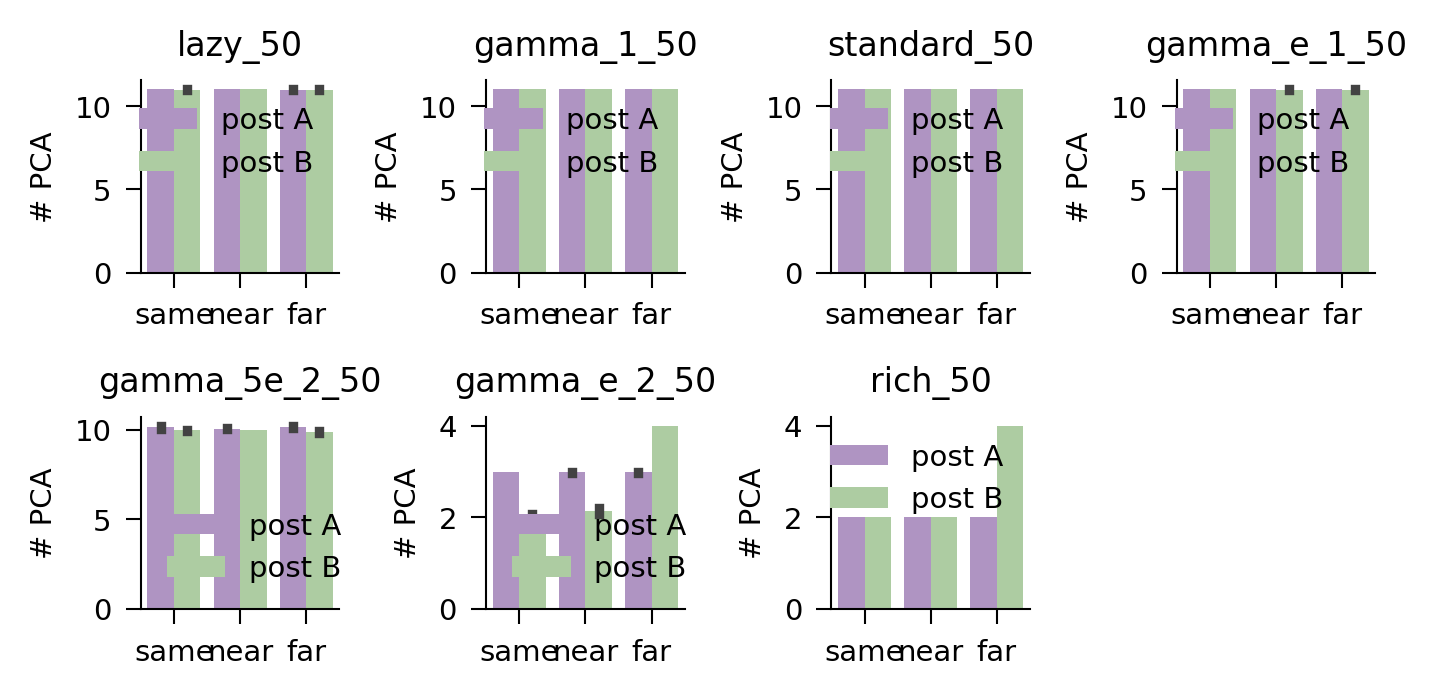

In [65]:
# Compute PCA components for all configurations
pca_dict = {}
for config in sim_configs:
    if config in ann_data_dict:
        pca_dict[config] = ann.compute_pca_components(ann_data_dict[config])

# Create comparison plot
fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])

for idx, config in enumerate([c for c in sim_configs if c in pca_dict]):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    figure_utils.plot_pca_components(pca_dict[config], task_colours, ax=ax)
    ax.set_title(config, fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)

# Remove empty subplots
n_plotted = len([c for c in sim_configs if c in pca_dict])
for idx in range(n_plotted, 8):
    row = idx // 4
    col = idx % 4
    axes[row, col].set_visible(False)

plt.tight_layout()

In [66]:
fig.savefig(os.path.join(figure_path, 'fig3E_pca_comparison.png'), 
            dpi=500, bbox_inches="tight")
plt.close(fig)

In [ ]:
# Load geometry results for all configurations
geom_dict = {}
for config in sim_configs:
    geom_path = project_root / f'data/simulations/geom_results_{config}.npz'
    if geom_path.exists():
        geom_dict[config] = np.load(geom_path)
    else:
        print(f"Warning: {config} geometry results not found, skipping...")

# Plot post-A geometry for all configurations
if len(geom_dict) > 0:
    # Compute axis limits across all configs for consistency
    all_A_pca_data = []
    for config in [c for c in sim_configs if c in geom_dict]:
        hiddens_postA, _, _, _ = ann.get_hiddens(geom_dict[config])
        pca, _ = ann.prepare_pca_single_task(hiddens_postA)
        A_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postA)
        all_A_pca_data.append(A_hidden_2d_pca)
    
    # Get combined limits
    all_A_combined = np.vstack(all_A_pca_data)
    lims = figure_utils.get_axis_limits(all_A_combined)
    
    # Create comparison plot for post-A geometry
    fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])
    
    for idx, config in enumerate([c for c in sim_configs if c in geom_dict]):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        hiddens_postA, _, _, _ = ann.get_hiddens(geom_dict[config])
        pca, _ = ann.prepare_pca_single_task(hiddens_postA)
        A_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postA)
        
        figure_utils.plot_split_stim(ax, A_hidden_2d_pca, task_colours, lims)
        ax.set_title(config, fontsize=8)
        ax.xaxis.label.set_fontsize(7)
        ax.yaxis.label.set_fontsize(7)
        ax.tick_params(labelsize=7)
    
    # Remove empty subplots
    n_plotted = len([c for c in sim_configs if c in geom_dict])
    for idx in range(n_plotted, 8):
        row = idx // 4
        col = idx % 4
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    fig.savefig(os.path.join(figure_path, 'supp_A_geom_comparison.png'), 
                dpi=500, bbox_inches="tight")
    plt.close(fig)
    
    # Plot post-B geometry for each condition (same, near, far)
    for cond_idx, (cond_name, letter) in enumerate(zip(['same', 'near', 'far'], ['F', 'G', 'H'])):
        # Compute axis limits across all configs for this condition
        all_B_pca_data = []
        for config in [c for c in sim_configs if c in geom_dict]:
            _, same_hiddens, near_hiddens, far_hiddens = ann.get_hiddens(geom_dict[config])
            hiddens_postB = [same_hiddens, near_hiddens, far_hiddens][cond_idx]
            pca, _ = ann.prepare_pca_single_task(hiddens_postB)
            B_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postB)
            all_B_pca_data.append(B_hidden_2d_pca)
        
        # Get combined limits
        all_B_combined = np.vstack(all_B_pca_data)
        lims = figure_utils.get_axis_limits(all_B_combined)
        
        # Create comparison plot for this condition
        fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])
        
        for idx, config in enumerate([c for c in sim_configs if c in geom_dict]):
            row = idx // 4
            col = idx % 4
            ax = axes[row, col]
            
            _, same_hiddens, near_hiddens, far_hiddens = ann.get_hiddens(geom_dict[config])
            hiddens_postB = [same_hiddens, near_hiddens, far_hiddens][cond_idx]
            pca, _ = ann.prepare_pca_single_task(hiddens_postB)
            B_hidden_2d_pca = ann.project_onto_pca(pca, hiddens_postB)
            
            figure_utils.plot_split_stim(ax, B_hidden_2d_pca, task_colours, lims)
            ax.set_title(config, fontsize=8)
            ax.xaxis.label.set_fontsize(7)
            ax.yaxis.label.set_fontsize(7)
            ax.tick_params(labelsize=7)
        
        # Remove empty subplots
        n_plotted = len([c for c in sim_configs if c in geom_dict])
        for idx in range(n_plotted, 8):
            row = idx // 4
            col = idx % 4
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        fig.savefig(os.path.join(figure_path, f'fig3{letter}_geom_comparison.png'), 
                    dpi=500, bbox_inches="tight")
        plt.close(fig)

## Principal angles - Comparison across configurations

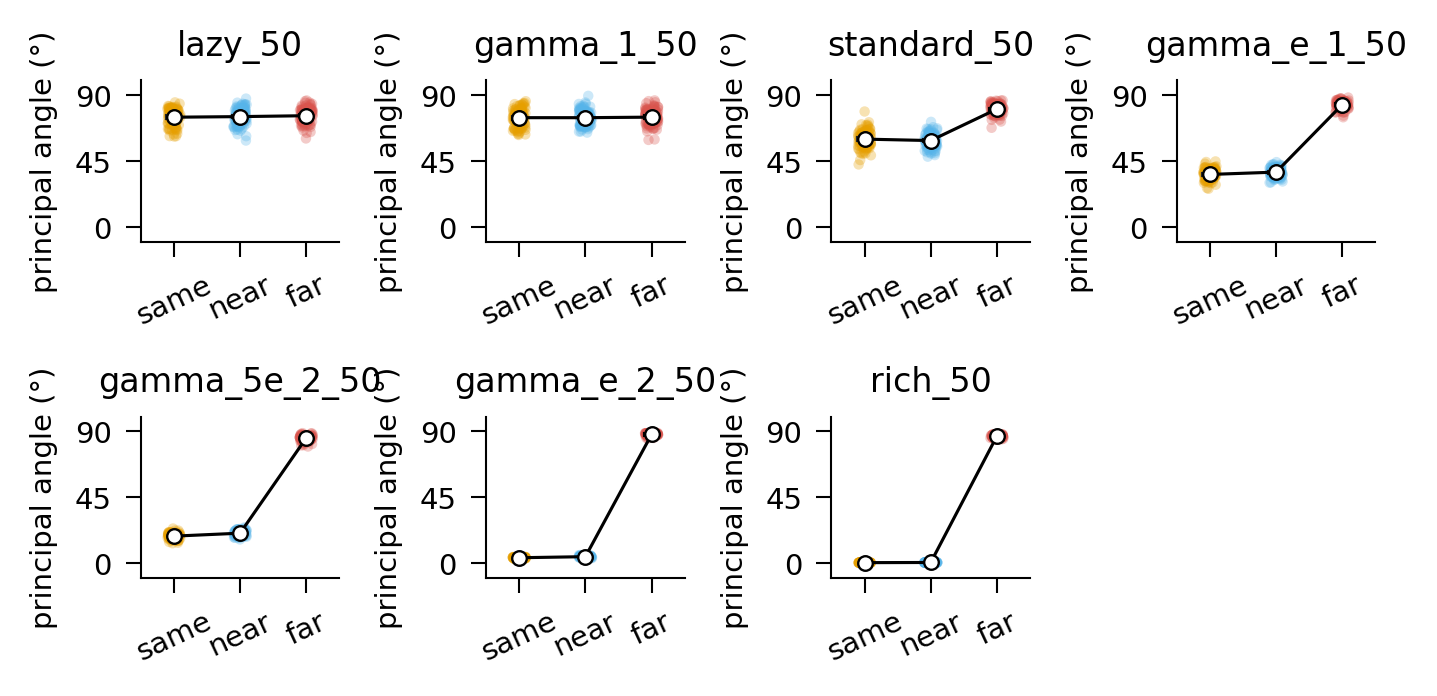

In [67]:
# Compute principal angles for all configurations
pa_dict = {}
for config in sim_configs:
    if config in ann_data_dict:
        pa_dict[config] = ann.get_principal_angles(ann_data_dict[config])

# Create comparison plot
fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])

for idx, config in enumerate([c for c in sim_configs if c in pa_dict]):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    figure_utils.plot_transfer(
        pa_dict[config], 'principal_angle_between', ['same', 'near', 'far'], 
        ylabel='principal angle (°)', 
        xlim=(-0.5, 2.5), ylim=(-10, 100), 
        yticks=np.arange(0, 91, 45), 
        schedule_colours=schedule_colours, 
        p_values=np.nan, addtests=0, markersize=3, scatter=False, 
        figsize=[3*cm_conv, 3*cm_conv], ax=ax
    )
    ax.set_title(config, fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)

# Remove empty subplots
n_plotted = len([c for c in sim_configs if c in pa_dict])
for idx in range(n_plotted, 8):
    row = idx // 4
    col = idx % 4
    axes[row, col].set_visible(False)

plt.tight_layout()

In [68]:
fig.savefig(os.path.join(figure_path, 'fig3I_principal_angle_comparison.png'), 
            dpi=500, bbox_inches="tight")
plt.close(fig)